# Land Cover Types and Elevation Predictions

The data for this project is a subset of the forest cover type data that has been used in several machine learning publications.  Find the subset of the data that you should use for the exam in my [Data GitHub repository](https://github.com/esnt/Data/tree/main/Forest) in the file called `forest.csv` ("Forest" folder in the main Data repo). 

Please include the requested code (and ONLY the requested code) in the appropriate cells below the questions.  Extra code that you used for exploring the data, building and evaluating models, and anything else, should be *well-documented* and included at the end of the notebook. As you answer the questions below, keep the following in mind:

* There is not necessarily a "best" model that I am expecting you to find
* You do not need to try every single type of model that we have learned in class, but I am interested in the reasons that you chose to use or not use certain models.
* I should be able to run your notebook without error
* You should not use ChatGPT or similar tool to help you write the code or answer the questions, but you are allowed to use the books, LearningSuite, and the internet.

When you are finished, upload this .ipynb file to the Gradescrope assignment. 

### Variables

Here is a description of the variables included in the data.  The target is `Cover_Type`.

**Name / Data Type / Measurement / Description**

* Elevation / quantitative /meters / Elevation in meters
* Aspect / quantitative / azimuth / Aspect in degrees azimuth
* Slope / quantitative / degrees / Slope in degrees
* Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
* Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features
* Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway
* Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice
* Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice
* Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice
* Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points
* Wilderness_Area / qualitative / A1-A4 / Wilderness area designation
* Soil_Type  / qualitative / S1-S40 / Soil Type designation
* Cover_Type (2 types) / integer / 1 and 2 / Forest Cover Type designation (original data has 7 types)

## 1. Importing libraries
Import all the libraries that are necessary for running your code. 

In [142]:
# code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.metrics as skm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

Print the version of pandas and scikit-learn that you are using but running the cell below.  

In [117]:
import sklearn
import pandas as pd
print("Pandas: "+ pd.__version__)
print("Sklearn: "+ sklearn.__version__)

Pandas: 1.4.1
Sklearn: 1.0.2


---
## 2. Importing the data

Import the data

In [151]:
# code here
df=pd.read_csv('forest.csv')

---
## 3.  Processing the data

In [162]:
# code here

# select only the categorical columns
categorical_columns = ['Soil_Type', 'Wilderness_Area']
categorical_data = df[categorical_columns]

# create an instance of OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the categorical data
categorical_data = encoder.fit_transform(categorical_data)

# convert the sparse matrix to a dataframe
categorical_data = pd.DataFrame(categorical_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# drop the original categorical columns from the original dataframe
df = df.drop(categorical_columns, axis=1)

# concatenate the dataframes to create a final dataframe with only numerical values
df = pd.concat([df, categorical_data], axis=1)

#rearange dataframe
df = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type_T10',
       'Soil_Type_T11', 'Soil_Type_T12', 'Soil_Type_T13', 'Soil_Type_T16',
       'Soil_Type_T17', 'Soil_Type_T18', 'Soil_Type_T19', 'Soil_Type_T2',
       'Soil_Type_T20', 'Soil_Type_T21', 'Soil_Type_T22', 'Soil_Type_T23',
       'Soil_Type_T24', 'Soil_Type_T25', 'Soil_Type_T26', 'Soil_Type_T27',
       'Soil_Type_T28', 'Soil_Type_T29', 'Soil_Type_T3', 'Soil_Type_T30',
       'Soil_Type_T31', 'Soil_Type_T32', 'Soil_Type_T33', 'Soil_Type_T34',
       'Soil_Type_T35', 'Soil_Type_T36', 'Soil_Type_T38', 'Soil_Type_T39',
       'Soil_Type_T4', 'Soil_Type_T40', 'Soil_Type_T6', 'Soil_Type_T7',
       'Soil_Type_T8', 'Soil_Type_T9', 'Soil_Type_nan', 'Wilderness_Area_A1',
       'Wilderness_Area_A2', 'Wilderness_Area_A3', 'Wilderness_Area_A4',
       'Wilderness_Area_nan', 'Cover_Type']]

#Separate response from explanatory variables
y =df['Cover_Type']
X = df.loc[:,'Elevation':'Wilderness_Area_nan'] 

#Split the data into a training and test set with 25% of the data in the test set and random state=307.
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25, random_state=307)

#Create a processing pipeline using that fills missing values and transforms the predictors to the same scale.
pipe = Pipeline([('impute', SimpleImputer(strategy="mean")),
                ('scaler', StandardScaler()),
                ])

#Update the X-training data by first fitting and then transforming the original Xtraining data with the processing pipeline
Xtrain = pipe.fit_transform(Xtrain)

#Update the X-test data by transforming the original X-test data with the pipeline trained in the previous step
Xtest = pipe.transform(Xtest)

#### In the markdown cell below, describe the way you decided to process the data and the reasons behind those choices

I decided to first, convert categorical varibles to numeric with onehot encoder, then create training and testing sets, and finally piping the sets in order to scale and impute missing values

---
## 4. Fitting a classification model

 Build an appropriate classification model that is NOT an ensemble.  This model should have optimized hyperparameters.   Report the generalization (1) accuracy, (2) F1, and (3) AUC.

Include only the code that fits the model and computes your best estimates of the generalization metrics.   

For example, the code in the box should be something like:
```
clf = MyBestClassifier(hyperparameters = tuned_values)
# code to fit model (not commented)
# code to compute generalization metrics (not commented)
print(accuracy)
print(F1)
print(AUC)
```

In [163]:
# ** THE ADDITIONAL CODE SECTION HAS THE CODE FOR OPTIMIZING PARAMETERS WITH GRIDSEARCH **
 
#create and fit classifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=12)
tree.fit(Xtrain, ytrain)

#predict with test set
ypred = tree.predict(Xtest)

#print generalization metrics
print("Accuracy:", skm.accuracy_score(ytest, ypred))
print(skm.classification_report(ytest, ypred))
print("AUC:", skm.roc_auc_score(ytest, ypred))

Accuracy: 0.8183079056865464
              precision    recall  f1-score   support

         1.0       0.79      0.78      0.78      3698
         2.0       0.84      0.85      0.84      4954

    accuracy                           0.82      8652
   macro avg       0.81      0.81      0.81      8652
weighted avg       0.82      0.82      0.82      8652

AUC: 0.8128539185711358


#### In the markdown cell below, describe the process that you used to build your model.

Be sure to include why or why not you chose to consider different (non-ensemble) models that we've learned about and how you optimized any relevant hyperparameters in your final model.

Non-Ensemble models can be good when we can't afford a lot of computation. Bigger data sets can be good for non-ensemble models because there is enough data to find decent predictions and performance.
I used the decision tree classifier, optimized by running a gridsearch with multiple values for the parameters, then found the best ones and fitted it with the training data and made predictions.

---
## 5. Fitting another classification model

Build an appropriate classification model that IS an ensemble and report the generalization (1) accuracy, (2) F1, and (3) AUC.

Include only the code that fits the model and computes your best estimates of the generalization metrics. 

In [164]:
# code here

#create and fit classifier
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_features='log2')
rf.fit(Xtrain, ytrain)

#predict with test set
ypred = rf.predict(Xtest)

#print generalization metrics
print("Accuracy:", skm.accuracy_score(ytest, ypred))
print(skm.classification_report(ytest, ypred))
print("AUC:", skm.roc_auc_score(ytest, ypred))

Accuracy: 0.8688164586222838
              precision    recall  f1-score   support

         1.0       0.87      0.82      0.84      3698
         2.0       0.87      0.91      0.89      4954

    accuracy                           0.87      8652
   macro avg       0.87      0.86      0.86      8652
weighted avg       0.87      0.87      0.87      8652

AUC: 0.8621016433939676


#### In the markdown cell below, describe the process that you used to build your model.

Be sure to include why or why not you chose to consider different (ensemble) models that we've learned about and how you optimized any relevant hyperparameters in your final model.

Ensemble models are great because they use different models and combine all their best parts to come up with the best performance possible. We can see that the metrics were better overall than the non-ensemble model.
I used the random forest classifier, optimized by running with a few different values for the parameters, then fitted it with the training data and made predictions.


---
## 6.  Generalization Metrics

In the markdown cell below, describe how you chose to estimate and compute the generalization metrics.  

I used the metrics elements from sklearn. I included the predictions and the true values to obtain the socres of the metrics.

---
## 7. Important variables

If possible, say which variables seem to be the most important for the prediction.  Also comment briefly on how you determined which variables are important. If it is not possible, say why not.  

In [ ]:
#** Please see the additional code section to find the code where I found the most important variables. ** 

#The top 3 variables that seem most important for prediction are Elevation, Vertical_Distance_To_Hydrology, and Hillshade_3pm. 
#The "feature_importances" attribute in the classifiers can show which variables are the most important, they I just plotted them

---
## 8. Making Predictions

Use your best model (the one from either part 4 or part 5) to predict the classes for the instances in the `newdata.csv` file.  Show the code you use to make the prediction and the predictions themselve (there are only 10 new instances, so it is possible print them out)


In [123]:
# ** PLEASE GO TO THE BOTOM OF THE NOTEBOOK FIRST, AND RUN THE CODE FOR Q8 TO PREPARE DATASET, THEN RUN THIS BOX **

#Predict and print
preds = rf.predict(new_pred)
print(preds)

[2. 1. 2. 2. 2. 1. 2. 2. 2. 1.]


---
## 9.  Regression

Now suppose that you want to predict "Elevation". Repeat steps (2) and (3).  This time use "Elevation" as the target and the other variables (except "Cover_Type") as the predictors.  

In [124]:
#STEPS FROM 2 & 3:

# code here
df=pd.read_csv('forest.csv')

# select only the categorical columns
categorical_columns = ['Soil_Type', 'Wilderness_Area']
categorical_data = df[categorical_columns]

# create an instance of OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the categorical data
categorical_data = encoder.fit_transform(categorical_data)

# convert the sparse matrix to a dataframe
categorical_data = pd.DataFrame(categorical_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# drop the original categorical columns from the original dataframe
df = df.drop(categorical_columns, axis=1)

# concatenate the dataframes to create a final dataframe with only numerical values
df = pd.concat([df, categorical_data], axis=1)

#rearange dataframe
df = df[['Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type_T10',
       'Soil_Type_T11', 'Soil_Type_T12', 'Soil_Type_T13', 'Soil_Type_T16',
       'Soil_Type_T17', 'Soil_Type_T18', 'Soil_Type_T19', 'Soil_Type_T2',
       'Soil_Type_T20', 'Soil_Type_T21', 'Soil_Type_T22', 'Soil_Type_T23',
       'Soil_Type_T24', 'Soil_Type_T25', 'Soil_Type_T26', 'Soil_Type_T27',
       'Soil_Type_T28', 'Soil_Type_T29', 'Soil_Type_T3', 'Soil_Type_T30',
       'Soil_Type_T31', 'Soil_Type_T32', 'Soil_Type_T33', 'Soil_Type_T34',
       'Soil_Type_T35', 'Soil_Type_T36', 'Soil_Type_T38', 'Soil_Type_T39',
       'Soil_Type_T4', 'Soil_Type_T40', 'Soil_Type_T6', 'Soil_Type_T7',
       'Soil_Type_T8', 'Soil_Type_T9', 'Soil_Type_nan', 'Wilderness_Area_A1',
       'Wilderness_Area_A2', 'Wilderness_Area_A3', 'Wilderness_Area_A4',
       'Wilderness_Area_nan', 'Elevation']]

#Separate response from explanatory variables
y =df['Elevation']
X = df.loc[:,'Aspect':'Wilderness_Area_nan'] 

#Split the data into a training and test set with 25% of the data in the test set and random state=307.
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25, random_state=307)

#Create a processing pipeline using that fills missing values and transforms the predictors to the same scale.
pipe = Pipeline([('impute', SimpleImputer(strategy="mean")),
                ('scaler', StandardScaler()),
                ])

#Update the X-training data by first fitting and then transforming the original Xtraining data with the processing pipeline
Xtrain = pipe.fit_transform(Xtrain)

#Update the X-test data by transforming the original X-test data with the pipeline trained in the previous step
Xtest = pipe.transform(Xtest)

Run a linear regression model.  Compute the generalization RSME.

In [125]:
# code here

#Fit Linear Regression model
reg = LinearRegression()
reg.fit(Xtrain, ytrain)

#predict with test set
ypred = reg.predict(Xtest)

#get and print RMSE
rmse = skm.mean_squared_error(ytest, ypred, squared=False)
print(rmse)


133.7872802475873


Based on the generalization RSME, comment on how well your model performs in the markdown cell below.  For example, to what value should you compare the RMSE to determine if your model as any predictive power?

Based on Elevation values from 2182 to 3675, an RMSE value of 133.79 (normalized as .09) is very good, which indicates that the model performs very well.

---
# Additional code

Include the rest of the code that you used to answers the questions.  Please have neat, well commented code.  If you used a .py file, copy and paste your code in the cell below. 

In [81]:
# ** CODE FOR Q4 **
# ** Tuning parameters for Q4 **

# Create the parameter grid based on the results of random search 
parameters = {"criterion": ('gini', 'entropy'), "max_depth":[2,4,6,8,10,12]}

#create classifier
tree = DecisionTreeClassifier()

clf_GS = GridSearchCV(tree, parameters)
clf_GS.fit(Xtrain, ytrain)
clf_GS.best_params_

{'criterion': 'gini', 'max_depth': 12}

In [ ]:
# ** CODE FOR Q4 **
# ** Tuning parameters for Q4 **

# Create the parameter grid based on the results of random search 
parameters = {"criterion": ('gini', 'entropy'), "max_depth":[2,4,6,8,10,12]}

#create classifier
tree = DecisionTreeClassifier()

clf_GS = GridSearchCV(tree, parameters)
clf_GS.fit(Xtrain, ytrain)
clf_GS.best_params_

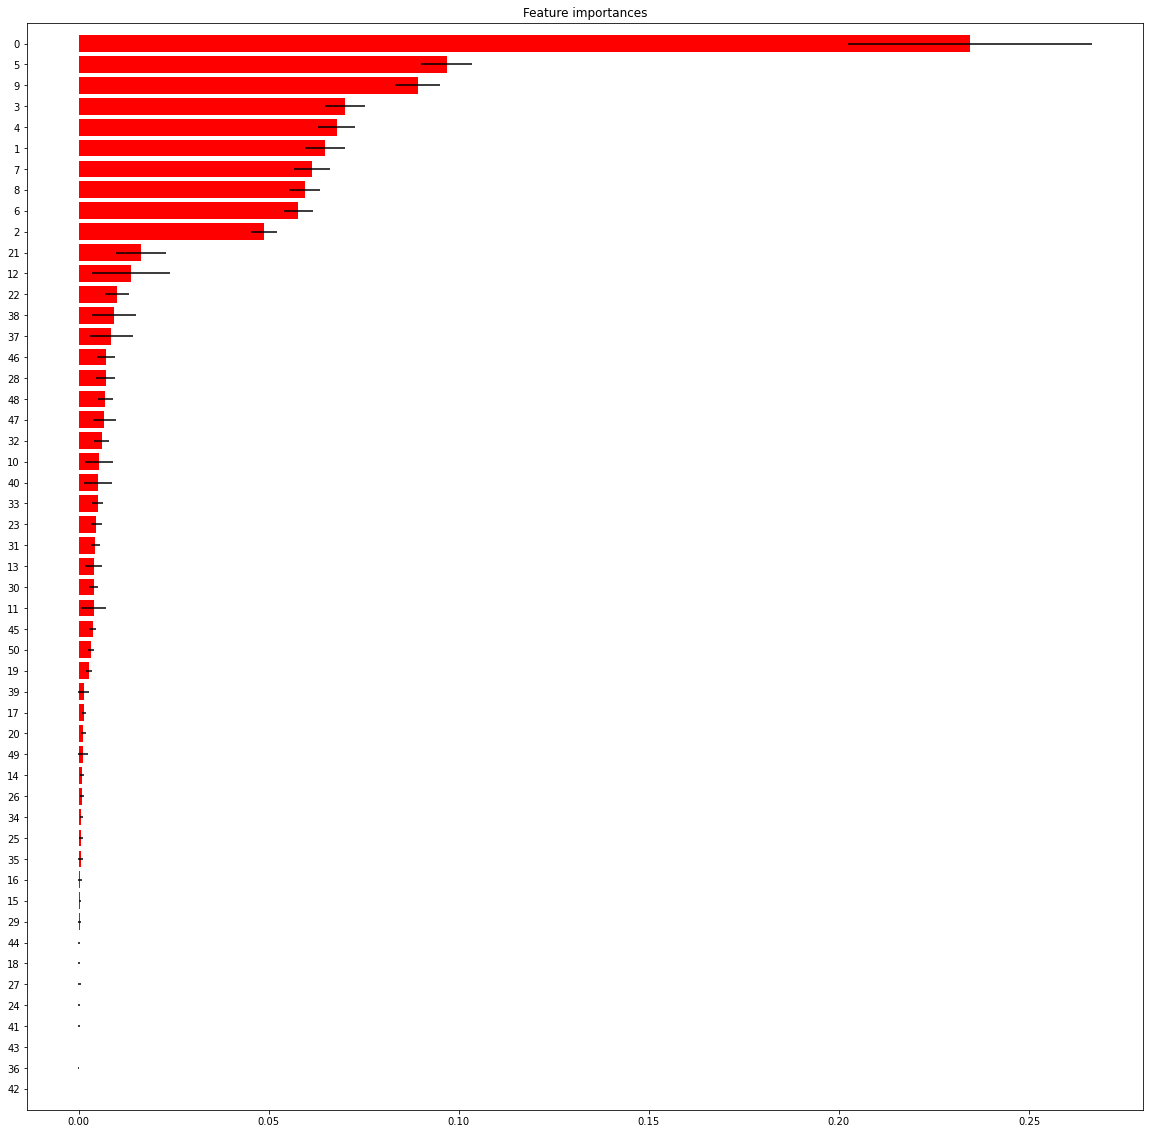

In [170]:
# ** CODE FOR Q7 **

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(20,20))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [122]:
# ** CODE FOR Q8 **

#Preparing newdata.csv set for predictions in Q8:

new_pred = pd.read_csv('newdata.csv')

#transform df to numerical with onehotencoder

# select only the categorical columns
categorical_columns = ['Soil_Type', 'Wilderness_Area']
categorical_data = new_pred[categorical_columns]

# create an instance of OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the categorical data
categorical_data = encoder.fit_transform(categorical_data)

# convert the sparse matrix to a dataframe
categorical_data = pd.DataFrame(categorical_data.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# drop the original categorical columns from the original dataframe
new_pred = new_pred.drop(categorical_columns, axis=1)

# concatenate the dataframes to create a final dataframe with only numerical values
new_pred = pd.concat([new_pred, categorical_data], axis=1)

#Add missing zero columns from train set to match prediction
new_pred[['Soil_Type_T11', 'Soil_Type_T13', 'Soil_Type_T16',
       'Soil_Type_T17', 'Soil_Type_T18', 'Soil_Type_T19', 'Soil_Type_T2',
       'Soil_Type_T20', 'Soil_Type_T21',
       'Soil_Type_T24', 'Soil_Type_T25', 'Soil_Type_T26', 'Soil_Type_T27',
       'Soil_Type_T28',  'Soil_Type_T3', 'Soil_Type_T30',
       'Soil_Type_T31', 'Soil_Type_T34',
       'Soil_Type_T35', 'Soil_Type_T36', 'Soil_Type_T38', 'Soil_Type_T39',
       'Soil_Type_T4', 'Soil_Type_T40', 'Soil_Type_T6', 'Soil_Type_T7',
       'Soil_Type_T8', 'Soil_Type_T9', 'Soil_Type_nan', 
       'Wilderness_Area_A2', 'Wilderness_Area_A4',
       'Wilderness_Area_nan',]] = 0

#rearange dataframe
new_pred = new_pred[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Soil_Type_T10',
       'Soil_Type_T11', 'Soil_Type_T12', 'Soil_Type_T13', 'Soil_Type_T16',
       'Soil_Type_T17', 'Soil_Type_T18', 'Soil_Type_T19', 'Soil_Type_T2',
       'Soil_Type_T20', 'Soil_Type_T21', 'Soil_Type_T22', 'Soil_Type_T23',
       'Soil_Type_T24', 'Soil_Type_T25', 'Soil_Type_T26', 'Soil_Type_T27',
       'Soil_Type_T28', 'Soil_Type_T29', 'Soil_Type_T3', 'Soil_Type_T30',
       'Soil_Type_T31', 'Soil_Type_T32', 'Soil_Type_T33', 'Soil_Type_T34',
       'Soil_Type_T35', 'Soil_Type_T36', 'Soil_Type_T38', 'Soil_Type_T39',
       'Soil_Type_T4', 'Soil_Type_T40', 'Soil_Type_T6', 'Soil_Type_T7',
       'Soil_Type_T8', 'Soil_Type_T9', 'Soil_Type_nan', 'Wilderness_Area_A1',
       'Wilderness_Area_A2', 'Wilderness_Area_A3', 'Wilderness_Area_A4',
       'Wilderness_Area_nan']]

#Update the X-test data by transforming the original X-test data with the pipeline trained in the previous step
new_pred = pipe.transform(new_pred)

In [109]:
# ** CODE Q9 **

#Normalized RMSE

rmse / (df['Elevation'].max() - df['Elevation'].min())

0.08960969875926811